In [1]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from braingeneers.analysis import plot
from braingeneers.analysis import single_unit
import matplotlib
import os
import zipfile
plt.style.use('default')
# save pdf for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
def load_curation(qm_path):
    with zipfile.ZipFile(qm_path, 'r') as f_zip:
        qm = f_zip.open("qm.npz")
        data = np.load(qm, allow_pickle=True)
        spike_times = data["train"].item()
        fs = data["fs"]
        train = [times / fs for _, times in spike_times.items()]
        if "config" in data:
            config = data["config"].item()
        else:
            config = None
        neuron_data = data["neuron_data"].item()
    return train, neuron_data, config, fs

##### File path to spontaneous + stim

In [3]:
spt_folder_dir = "/home/kang/disk/Opto/20231203"
file_name = "Hc112823_avv9hckcr1_21841_120323_3"

rec_path = f"{spt_folder_dir}/{file_name}.raw.h5"
print(rec_path)
curation_path = f"{spt_folder_dir}/qm/{file_name}_acqm.zip"
phy_path = f"{spt_folder_dir}/phy/{file_name}_phy.zip"
print(curation_path)
print(file_name)

/home/kang/disk/Opto/20231203/Hc112823_avv9hckcr1_21841_120323_3.raw.h5
/home/kang/disk/Opto/20231203/qm/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip
Hc112823_avv9hckcr1_21841_120323_3


In [4]:
train, neuron_data, config, fs = load_curation(curation_path)
spike_data_phy = analysis.read_phy_files(phy_path)
print(spike_data_phy.neuron_data[0][0].keys())

dict_keys(['cluster_id', 'channel', 'position', 'amplitudes', 'template', 'neighbor_channels', 'neighbor_positions', 'neighbor_templates'])


In [5]:
for i, phy_data in spike_data_phy.neuron_data[0].items():
    cluster_id  = phy_data["cluster_id"]
    for k, data in neuron_data.items():
        if data["cluster_id"] == cluster_id:
            data["amplitudes"] = phy_data["amplitudes"]

In [6]:
spike_data = analysis.SpikeData(train, neuron_data={0:neuron_data})
stim_pairs_all = ephys.load_gpio_maxwell(rec_path)
stim_pairs_all

array([[ 30.04035,  40.0403 ],
       [ 60.04155,  70.0415 ],
       [ 90.04355, 100.0435 ],
       [120.0436 , 130.04355],
       [150.04455, 160.04455],
       [180.0468 , 190.04675],
       [210.04675, 220.04675],
       [240.0475 , 250.04745],
       [270.04975, 280.0497 ],
       [300.0497 , 310.0497 ]])

#### firing rate for spt, 10-10-10 seconds
     - 160 to 310 s, rec Hc112823_avv9hckcr1_21841_120323_1
     - all of the 10 stims, rec Hc112823_avv9hckcr1_21841_120323_1
     - 20 to 170 s, rec Hc112823_avv9hckcr1_21841_120323_3
     - 170 to 320, rec Hc112823_avv9hckcr1_21841_120323_3
     - all of the 10 stims, rec Hc112823_avv9hckcr1_21841_120323_3

In [7]:
num_trial = 10
print(num_trial)

10


In [8]:
skip = True
if not skip:
    drop = []
    increase = []
    back_normal = []
    for i in range(num_trial):
        spike_data = spike_data_all[i]
        print(i, "Total num of units: ", spike_data.N)
        spike_times = np.sort(np.hstack(spike_data.train))
        length = (spike_times[-1] - spike_times[0])/1000
        stim_pairs = stim_pairs_all[i]
        print(stim_pairs.shape, stim_pairs, np.diff(stim_pairs))

        start = [stim_pairs[0][0]-10, stim_pairs[0][0], stim_pairs[0][0]+10]
        end = [stim_pairs[0][0], stim_pairs[0][0]+10, stim_pairs[0][0]+20]
        
        sub_1 =  spike_data.subtime(start[0]*1000.0, end[0]*1000.0)
        sub_2 = spike_data.subtime(start[1]*1000.0, end[1]*1000.0)
        counter_drop = 0
        no_drop = 0
        drop_id = []
        for n in range(spike_data.N):
            if len(sub_1.train[n]) > len(sub_2.train[n]):
                counter_drop += 1
                drop_id.append(n)
            else:
                no_drop += 1
        print("Percent of units having firing rate drop during stim: ", counter_drop/spike_data.N)
        # print("Percent of units no drop: ", no_drop/spike_data.N)
        drop.append(counter_drop/spike_data.N)
        # print(counter_drop, len(drop_id), drop_id)


        sub_3 = spike_data.subtime(start[2]*1000.0, end[2]*1000.0)
        counter_increase = 0
        extrem_increase = 0
        for n in drop_id:
            if len(sub_3.train[n]) > len(sub_2.train[n]):
                counter_increase += 1
            if len(sub_3.train[n]) >= len(sub_1.train[n]):
                extrem_increase += 1
        print("Percent of units having firing rate increase after stim: ", counter_increase/counter_drop)
        print("Percent of units having firing rate back to normal: ", extrem_increase/counter_drop)
        increase.append(counter_increase/counter_drop)
        back_normal.append(extrem_increase/counter_drop)

    print(np.mean(drop))
    print(np.mean(increase))
    print(np.mean(back_normal))
    

In [9]:
def plain_firing_rate(spike_data, rec_period, bin_size=0.1):
    [start, end] = rec_period
    spike_times = np.sort(np.hstack(spike_data.train))
    bins = np.arange(start, end+bin_size, bin_size)
    print(spike_times[-1], bins[-1])
    rate = (np.histogram(spike_times, bins)[0] / bin_size) / spike_data.N  # hz
    return bins, rate

In [10]:
spike_data_sub = []
all_rates = []
all_stim = []
stim_st_ind = 0
for i in range(stim_st_ind, stim_st_ind+num_trial, 1):
    stim_pairs = stim_pairs_all[i]
    print(stim_pairs.shape, stim_pairs, np.diff(stim_pairs))
    start = (stim_pairs[0] - 10) 
    end = (stim_pairs[0] + 10 + 10) 
    sub =  spike_data.subtime(start, end)
    spike_data_sub.append(sub)
    bins, rate = plain_firing_rate(sub, [0, 30], bin_size=1)
    print("number of bins", len(bins))
    all_rates.append(rate)
    all_stim.append(stim_pairs[0])

(2,) [30.04035 40.0403 ] [9.99995]
29.9999 30
number of bins 31
(2,) [60.04155 70.0415 ] [9.99995]
29.998850000000004 30
number of bins 31
(2,) [ 90.04355 100.0435 ] [9.99995]
30.0 30
number of bins 31
(2,) [120.0436  130.04355] [9.99995]
29.999899999999997 30
number of bins 31
(2,) [150.04455 160.04455] [10.]
29.998400000000004 30
number of bins 31
(2,) [180.0468  190.04675] [9.99995]
29.999500000000012 30
number of bins 31
(2,) [210.04675 220.04675] [10.]
29.997899999999987 30
number of bins 31
(2,) [240.0475  250.04745] [9.99995]
29.998099999999965 30
number of bins 31
(2,) [270.04975 280.0497 ] [9.99995]
29.999799999999993 30
number of bins 31
(2,) [300.0497 310.0497] [10.]
29.998450000000048 30
number of bins 31


In [11]:
print(all_rates)

[array([6.42924528, 3.68867925, 5.93396226, 3.37735849, 4.37735849,
       3.66037736, 3.40566038, 3.03301887, 2.96698113, 2.78301887,
       2.5754717 , 2.58490566, 2.75      , 2.8490566 , 2.67924528,
       2.86320755, 2.99528302, 3.42924528, 3.36792453, 3.61792453,
       5.64622642, 6.4009434 , 5.15566038, 5.01415094, 6.24056604,
       5.59433962, 6.24056604, 6.14150943, 5.96698113, 6.5754717 ]), array([3.69811321, 5.18867925, 4.35377358, 4.00943396, 3.29716981,
       3.19339623, 3.14622642, 3.11792453, 3.        , 3.22169811,
       2.74528302, 3.04716981, 2.99528302, 3.47641509, 3.3490566 ,
       3.44339623, 3.86792453, 3.99056604, 4.5       , 4.47641509,
       5.58490566, 6.88207547, 5.06603774, 6.29716981, 8.51886792,
       8.47169811, 8.74056604, 7.26415094, 7.27358491, 6.79245283]), array([ 5.91037736,  5.11320755,  4.3490566 ,  3.74528302,  3.53301887,
        3.33490566,  3.38679245,  3.19339623,  3.06603774,  3.13679245,
        2.83018868,  2.83018868,  3.05660377,  

In [12]:
import scipy
mean_rate = np.mean(all_rates, axis=0)
std_rate = np.std(all_rates, axis=0)
# sem_rate = np.std(all_rates, ddof=1) / np.sqrt(np.size(all_rates))
sem_rate = scipy.stats.sem(all_rates)
xx_bin = np.arange(1, 31, 1)
xx_stim = [10, 20]
print(len(mean_rate))

30


In [13]:
import scipy
sem_rate_test = np.array([np.std(rates, ddof=1) / np.sqrt(np.size(rates)) for rates in np.transpose(all_rates)])
print(sem_rate_test)
print(sem_rate)

[0.77480256 0.51836847 0.44592803 0.45395388 0.58082025 0.58559218
 0.59042377 0.70444961 0.58219268 0.46288625 0.52764766 0.43534045
 0.38890488 0.56889052 0.38400041 0.41260858 0.35718139 0.40059428
 0.27244866 0.22577877 0.35543718 0.48306902 0.40210659 0.42146179
 0.61231569 0.7047428  0.82635923 0.80842054 0.8001521  0.75967744]
[0.77480256 0.51836847 0.44592803 0.45395388 0.58082025 0.58559218
 0.59042377 0.70444961 0.58219268 0.46288625 0.52764766 0.43534045
 0.38890488 0.56889052 0.38400041 0.41260858 0.35718139 0.40059428
 0.27244866 0.22577877 0.35543718 0.48306902 0.40210659 0.42146179
 0.61231569 0.7047428  0.82635923 0.80842054 0.8001521  0.75967744]


In [14]:
np.transpose(all_rates).shape

(30, 10)

(-1.4, 31.4)

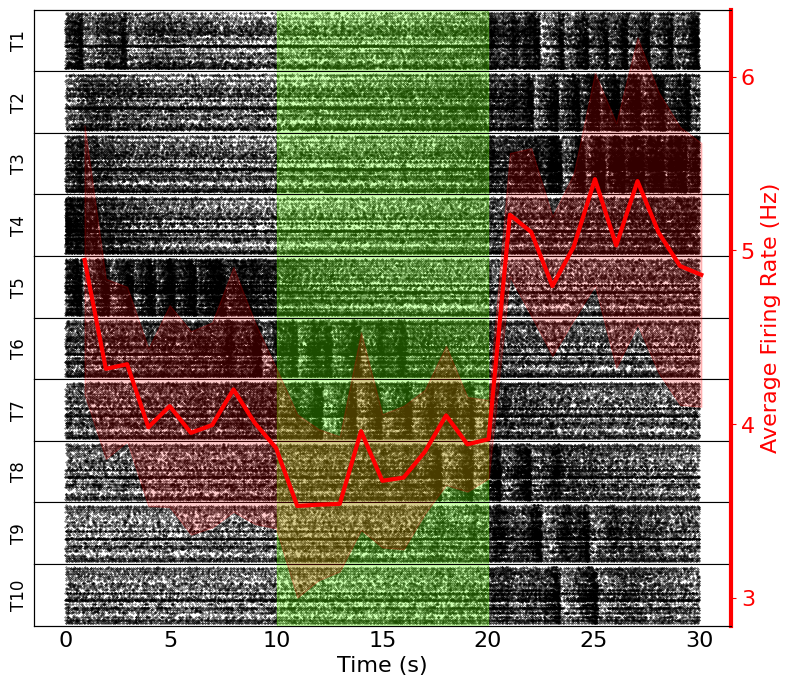

In [15]:
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
fig, axs = plt.subplots(num_trial, 1, figsize = (9,8))
axs1 = fig.add_subplot(111, facecolor="None")
axs1.yaxis.set_label_position("right")

for i in range(num_trial):
    st_trial = spike_data_sub[i].train
    for j in range(len(st_trial)):
        yy = [j] * len(st_trial[j])
        axs[i].scatter(np.asarray(st_trial[j]), yy, s=0.1, color='k')

    axs[i].get_xaxis().set_visible(False)
    # axs[i].get_yaxis().set_visible(False)
    plt.setp(axs[i].get_yticklabels(), visible=False)
    axs[i].tick_params(axis='both', which='both', length=0)
    axs[i].set_ylabel("T" + str(i+1), fontsize=12)
    axs[i].axvspan(xx_stim[0], xx_stim[1], color='#5EFF00', alpha=0.3)
axs[-1].get_xaxis().set_visible(True)
axs[-1].set_xlabel("Time (s)", fontsize=16)
axs[-1].xaxis.set_tick_params(labelsize=16)
plt.subplots_adjust(wspace=0, hspace=0)

axs1.plot(xx_bin, mean_rate, color='r', linewidth=3)
axs1.fill_between(xx_bin, mean_rate-sem_rate, mean_rate+sem_rate, color='r', alpha=0.2)
# axs1.axvspan(xx_stim[0], xx_stim[1], color='b', alpha=0.3)
axs1.set_ylabel("Average Firing Rate (Hz)", fontsize=16, color='r')
axs1.set_xlabel("Time (s)", fontsize=16)
axs1.yaxis.set_tick_params(labelsize=16)
axs1.get_xaxis().set_visible(False)
axs1.yaxis.set_major_locator(MaxNLocator(integer=True))
axs1.tick_params(left=False, right=True, labelleft=False, labelright=True,
                bottom=False, labelbottom=True)
axs1.spines['right'].set_color('r')
axs1.spines['right'].set_linewidth(3)
axs1.tick_params(axis='y', colors='r')
axs1.set_xlim(-1.4, 31.4)
# axs1.set_ylim(0, 3)
# plt.savefig(f"figureNew/raster_fr_ten_trails_{file_name}.png", transparent=True, dpi=300)
# plt.savefig(f"figureNew/raster_fr_ten_trails_{file_name}.pdf", transparent=True, dpi=300)


In [16]:
### box plot of firing rate during each section for each trial
fr_trial_section = dict.fromkeys(np.arange(num_trial))   # firing rate
# st_trial_section = dict.fromkeys(np.arange(num_trial))
amp_trial_section = dict.fromkeys(np.arange(num_trial))
mean_amp_trial_section = dict.fromkeys(np.arange(num_trial))
for i in range(num_trial):
    st_trial = spike_data_sub[i].train
    nd = spike_data_sub[i].neuron_data[0]
    amp_trial = [d["amplitudes"] for _, d in nd.items()]
    # pre_st, stim_st, post_st = [], [], []
    pre_fr, stim_fr, post_fr = [], [], []
    pre_amp, stim_amp, post_amp = [], [], []
    pre_mean_amp, stim_mean_amp, post_mean_amp = [], [], []
    for j in range(len(st_trial)):
        st = st_trial[j]
        amp = amp_trial[j]
        [pre_idx, post_idx] = np.searchsorted(st, [10, 20])
        pre_fr.append(len(st[:pre_idx])/10)
        pre_amp.append(amp[:pre_idx])
        pre_mean_amp.append(np.mean(amp[:pre_idx]))
        stim_fr.append(len(st[pre_idx: post_idx])/10)
        stim_amp.append(amp[pre_idx: post_idx])
        stim_mean_amp.append(np.mean(amp[pre_idx: post_idx]))
        post_fr.append(len(st[post_idx:])/10)
        post_amp.append(amp[post_idx:])
        post_mean_amp.append(np.mean(amp[post_idx:]))
        # pre_st.append(st[:pre_idx])
        # stim_st.append(st[pre_idx: post_idx]-10)
        # post_st.append(st[post_idx:]-20)
    # st_trial_section[i] = {"pre": pre_st, "stim": stim_st, "post": post_st}   
    fr_trial_section[i] = {"pre": pre_fr, "stim": stim_fr, "post": post_fr}   
    amp_trial_section[i] = {"pre": pre_amp, "stim": stim_amp, "post": post_amp}
    mean_amp_trial_section[i] = {"pre": pre_mean_amp, "stim": stim_mean_amp, "post": post_mean_amp}


/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
### save fr_trial_section to a csv for T-test on Pre-stim, stim-post, pre-post
import csv
import pandas as pd
# csv_columns = ["pre", "stim", "post"]
for i in range(num_trial):
    df = pd.DataFrame.from_dict(fr_trial_section[i])
    df = df.rename(columns={'pre': 'pre', 'stim': 'stim', 'post': 'post'})
    csv_file = f"figureNew/{file_name}/{file_name}_all_five_trials_t{str(i+1)}.csv"
    # df.to_csv(csv_file, index=False)
    # also save the mean amplitude for each section
    df_amp = pd.DataFrame.from_dict(mean_amp_trial_section[i])
    df_amp = df_amp.rename(columns={'pre': 'pre', 'stim': 'stim', 'post': 'post'})
    csv_file_amp = f"figureNew/{file_name}/{file_name}_all_ten_trials_amp_t{str(i+1)}.csv"
    df_amp.to_csv(csv_file_amp, index=False)

In [18]:
skip = True
if not skip:
    fig, axs = plt.subplots(figsize = (12,6), constrained_layout=True)
    reversed_trial = {"pre":[], "stim": [], "post": []}
    reversed_keys = ["pre", "stim", "post"]
    edge_colors = ["red", "blue", "g"]
    fill_colors = ["tan", "cyan", "green"]
    for i in range(num_trial):
        curr = fr_trial_section[i]
        reversed_trial["pre"].append(curr["pre"])
        reversed_trial["stim"].append(curr["stim"])
        reversed_trial["post"].append(curr["post"])

    bp = []
    for j in range(len(reversed_keys)):
        k = reversed_keys[j]
        # print(j, k, reversed_trial[k])
        bpl = axs.boxplot(reversed_trial[k], positions=np.arange(num_trial)+0.2*j, sym="", widths=0.1, 
                        whiskerprops=dict(linestyle='--',linewidth=2),
                        boxprops= dict(linewidth=2.0))
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bpl[element], color=edge_colors[j])
        bp.append(bpl)

    axs.legend([bpl["boxes"][0] for bpl in bp], reversed_keys, fontsize=12) 
    plt.xticks(np.arange(0, num_trial)+0.2, np.arange(num_trial)+1)
    axs.set_xlabel("Trial", fontsize=16)
    axs.set_ylabel("Firing Rate (Hz)", fontsize=16)
    axs.xaxis.set_tick_params(labelsize=16)
    axs.yaxis.set_tick_params(labelsize=16)
    plt.savefig(f"figureNew/boxplot_fr_ten_trails_{file_name}.png", transparent=True, dpi=300)
    plt.savefig(f"figureNew/boxplot_fr_ten_trails_{file_name}.pdf", transparent=True, dpi=300)

In [19]:
reversed_trial = {"pre":[], "stim": [], "post": []}
reversed_keys = ["pre", "stim", "post"]
edge_colors = ["red", "blue", "g"]
fill_colors = ["tan", "cyan", "green"]
for i in range(num_trial):
    curr = fr_trial_section[i]
    reversed_trial["pre"] += curr["pre"]
    reversed_trial["stim"] += curr["stim"]
    reversed_trial["post"] += curr["post"]
    
print(np.mean(reversed_trial["pre"]), 
        np.mean(reversed_trial["stim"]), 
        np.mean(reversed_trial["post"]))

4.171084905660377 3.7621698113207542 5.084150943396227


In [20]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame.from_dict(reversed_trial, orient='index').transpose()
print(df)

       pre  stim  post
0      6.0   1.2  10.1
1      4.3   3.0   5.6
2      6.6   5.9   9.9
3     15.0  12.0  11.6
4     24.2  20.1  25.6
...    ...   ...   ...
2115   8.0   8.4   8.4
2116   0.8   0.8   1.6
2117   0.3   0.1   0.2
2118   0.7   0.5   0.3
2119   0.2   0.1   3.7

[2120 rows x 3 columns]


In [21]:
### violin plot
skip = True
if not skip:
    fig, axs = plt.subplots(1, 1, figsize = (7, 5), constrained_layout=True)
    plt.suptitle("{}_fr_violin".format(file_name), fontsize=16)

    axs = sns.violinplot(data=df, inner=None, cut=0,
                        palette=["salmon", 'seagreen', 'cornflowerblue'], ax=axs)
    sns.stripplot(data=df, dodge=False, jitter=True, linewidth=0.4, size=3, 
                palette=['salmon', 'seagreen', 'cornflowerblue'],zorder=1, ax=axs)

    # sns.violinplot(data=df, x='label', y='value', hue='source', palette=['cornflowerblue', 'indianred'], saturation=0.5,
    #             inner="quartile", split=True, ax=axs1)
    sns.pointplot(data=df, linestyles="", dodge=True, 
                estimator='mean', markers=["D"], palette=['r'], ax=axs, label="Mean")
    plt.setp(axs.collections, zorder=100)
    axs.set_ylabel("Firing Rate (Hz)", fontsize=16)
    axs.set_xlabel("", fontsize=16)
    axs.xaxis.set_tick_params(labelsize=16)
    axs.yaxis.set_tick_params(labelsize=16)
    # axs.set_ylim(0, 8)
    axs.spines[['right', 'top']].set_visible(False)
    # axs.spines[['left', "bottom"]].set_linewidth(3)
    axs.legend(loc="upper right", fontsize=10)

    # plt.savefig("violin_fr_{}.svg".format(file_name), dpi=300)
    # plt.savefig("violin_fr_{}.png".format(file_name), transparent=True, dpi=300)


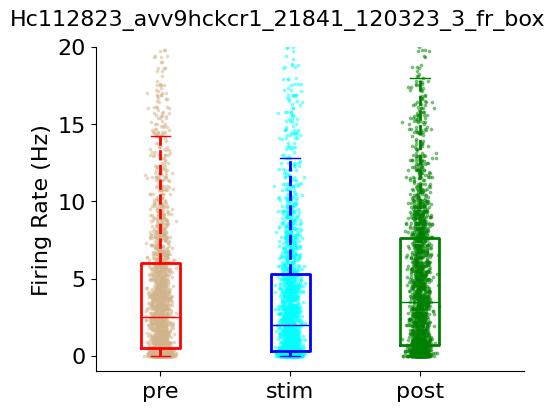

In [22]:
fig, axs = plt.subplots(figsize = (5, 4), constrained_layout=True)
plt.suptitle("{}_fr_box".format(file_name), fontsize=16)
bp = []
for j in range(len(reversed_keys)):
    k = reversed_keys[j]
    # print(j, k, reversed_trial[k])
    bpl = axs.boxplot(reversed_trial[k], positions=[j], sym="", widths=0.3, 
                      whiskerprops=dict(linestyle='--',linewidth=2),
                      boxprops= dict(linewidth=2.0))
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bpl[element], color=edge_colors[j])
    bp.append(bpl)

data = list(reversed_trial.values())
lines = []
for i, d in enumerate(data):
   y = d
   x = np.random.normal(i, 0.04, len(y))
   plt.scatter(x, y, s=3, color=fill_colors[i], alpha=0.4)
#    lines.append(list(zip(x, y)))
   
# for k in range(len(lines[0])):
#     axs.plot([lines[0][k][0], lines[1][k][0], lines[2][k][0]], 
#              [lines[0][k][1], lines[1][k][1], lines[2][k][1]],
#              color='grey', linewidth=0.5, alpha=0.2)


# axs.legend([bpl["boxes"][0] for bpl in bp], reversed_keys, loc="upper right", fontsize=12)
axs.set_xticks(np.arange(len(reversed_keys)), reversed_keys)
# axs.set_xlabel("Trial", fontsize=16)
axs.set_ylabel("Firing Rate (Hz)", fontsize=16)
axs.set_xlim(-0.5, 2.8)
axs.set_ylim(-1, 20)
axs.xaxis.set_tick_params(labelsize=16)
axs.yaxis.set_tick_params(labelsize=16)
axs.spines[['right', 'top']].set_visible(False)
# plt.grid(False)
# plt.savefig(f"figureNew/box_fr_ten_trials_{file_name}.png", dpi=300)
# plt.savefig(f"figureNew/box_fr_ten_trials_{file_name}.pdf", dpi=300)

In [23]:
### plot amplitude for each section
amp_reversed_trial = {"pre":[], "stim": [], "post": []}
reversed_keys = ["pre", "stim", "post"]
edge_colors = ["red", "blue", "g"]
fill_colors = ["tan", "cyan", "green"]
for i in range(num_trial):
    curr = mean_amp_trial_section[i]
    amp_reversed_trial["pre"] += curr["pre"]
    amp_reversed_trial["stim"] += curr["stim"]
    amp_reversed_trial["post"] += curr["post"]


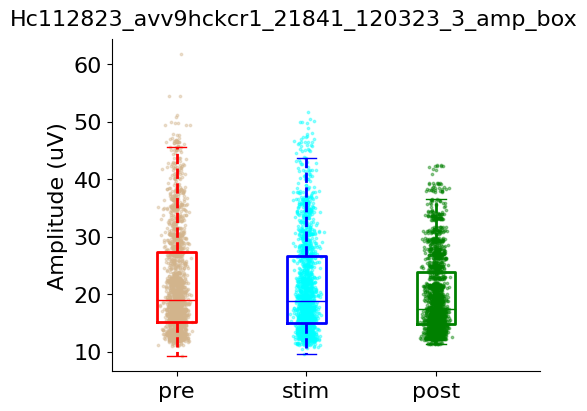

In [24]:
fig, axs = plt.subplots(figsize = (5, 4), constrained_layout=True)
plt.suptitle("{}_amp_box".format(file_name), fontsize=16)
bp = []
for j in range(len(reversed_keys)):
    k = reversed_keys[j]
    # print(j, k, reversed_trial[k])
    amp_array = np.array(amp_reversed_trial[k])
    filtered_amp = amp_array[~np.isnan(amp_array)]
    bpl = axs.boxplot(filtered_amp, positions=[j], sym="", widths=0.3, 
                      whiskerprops=dict(linestyle='--',linewidth=2),
                      boxprops= dict(linewidth=2.0))
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bpl[element], color=edge_colors[j])
    bp.append(bpl)

data = list(amp_reversed_trial.values())
lines = []
for i, d in enumerate(data):
   y = d
   x = np.random.normal(i, 0.04, len(y))
   plt.scatter(x, y, s=3, color=fill_colors[i], alpha=0.4)
#    lines.append(list(zip(x, y)))
   
# for k in range(len(lines[0])):
#     axs.plot([lines[0][k][0], lines[1][k][0], lines[2][k][0]], 
#              [lines[0][k][1], lines[1][k][1], lines[2][k][1]],
#              color='grey', linewidth=0.5, alpha=0.2)


# axs.legend([bpl["boxes"][0] for bpl in bp], reversed_keys, loc="upper right", fontsize=12)
axs.set_xticks(np.arange(len(reversed_keys)), reversed_keys)
# axs.set_xlabel("Trial", fontsize=16)
axs.set_ylabel("Amplitude (uV)", fontsize=16)
axs.set_xlim(-0.5, 2.8)
# axs.set_ylim(-1, 20)
axs.xaxis.set_tick_params(labelsize=16)
axs.yaxis.set_tick_params(labelsize=16)
axs.spines[['right', 'top']].set_visible(False)
# plt.grid(False)
plt.savefig(f"figureNew/{file_name}/box_amp_ten_trials_{file_name}.png", dpi=300)
plt.savefig(f"figureNew/{file_name}/box_amp_ten_trials_{file_name}.pdf", dpi=300)

#### sttc heatmap of each trial

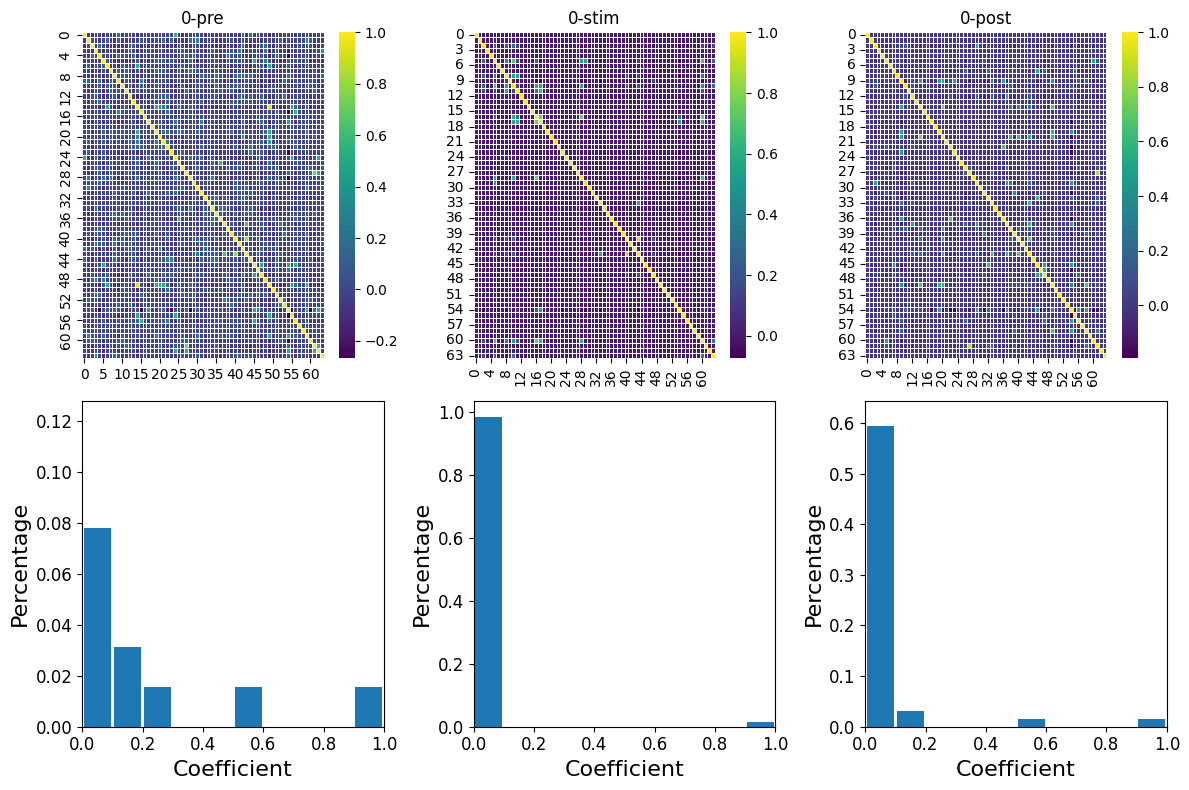

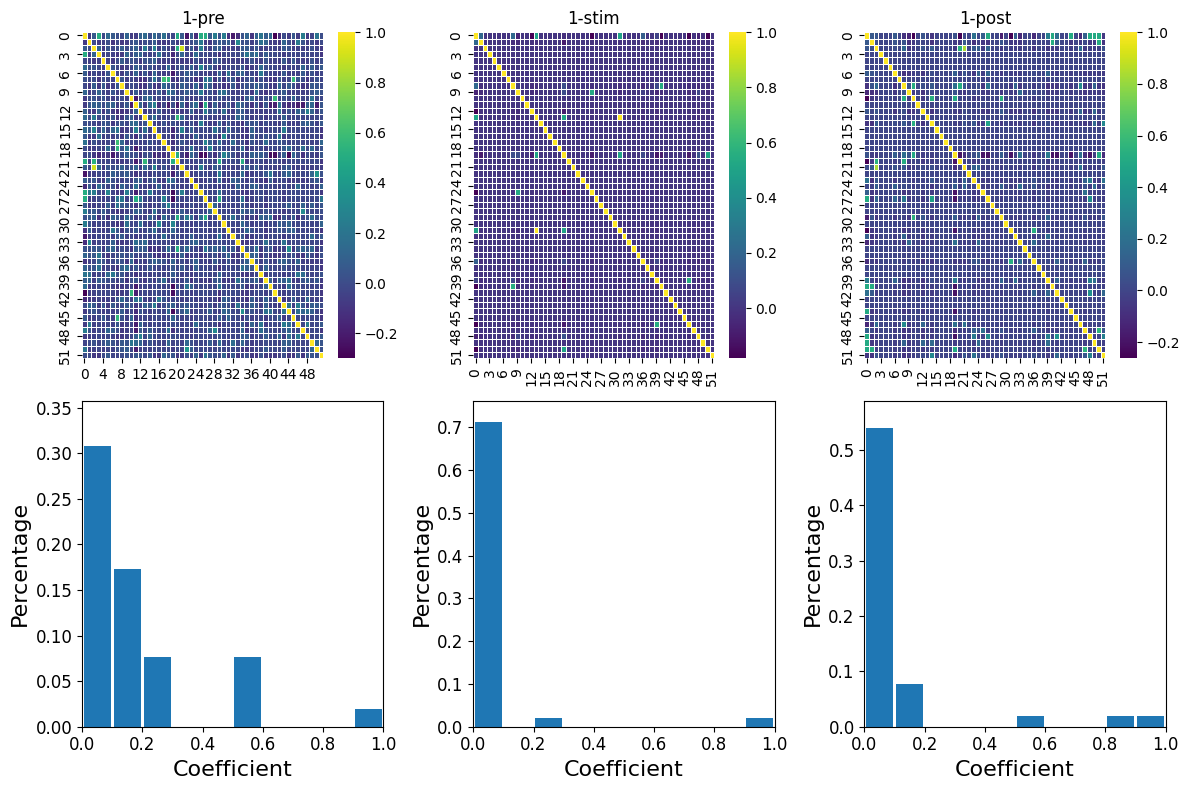

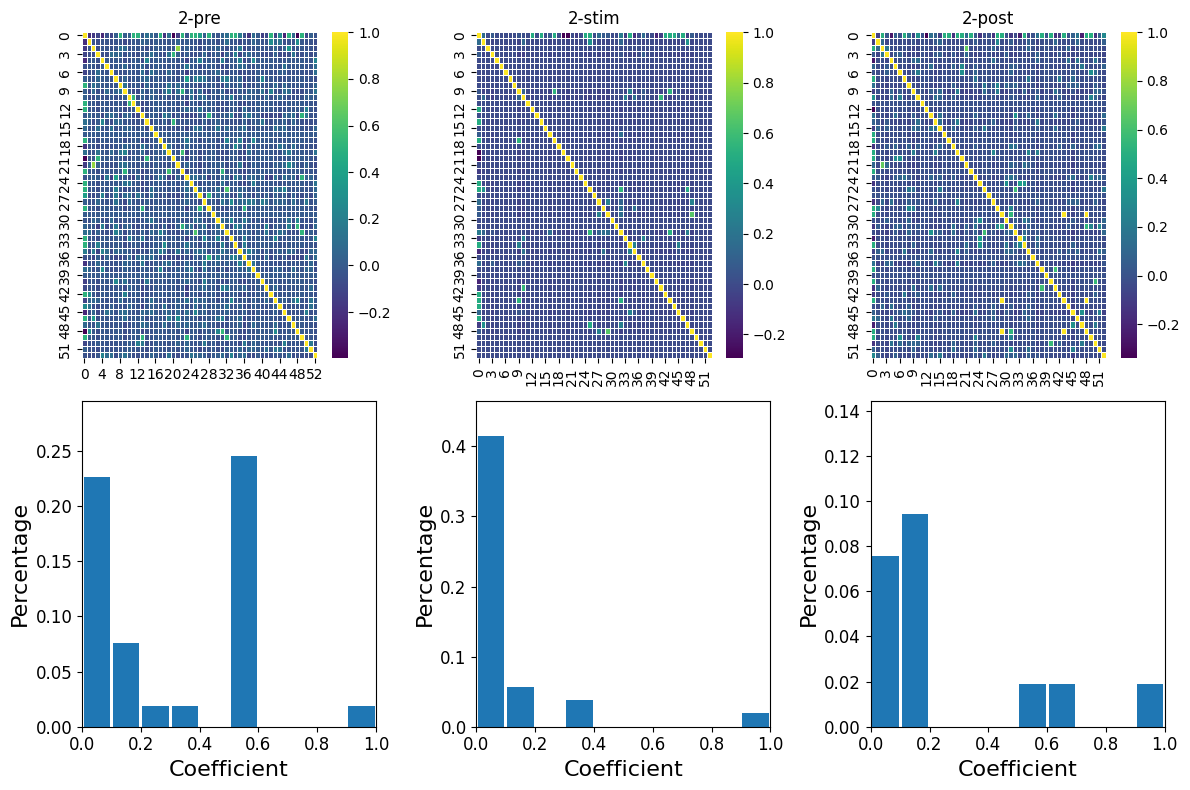

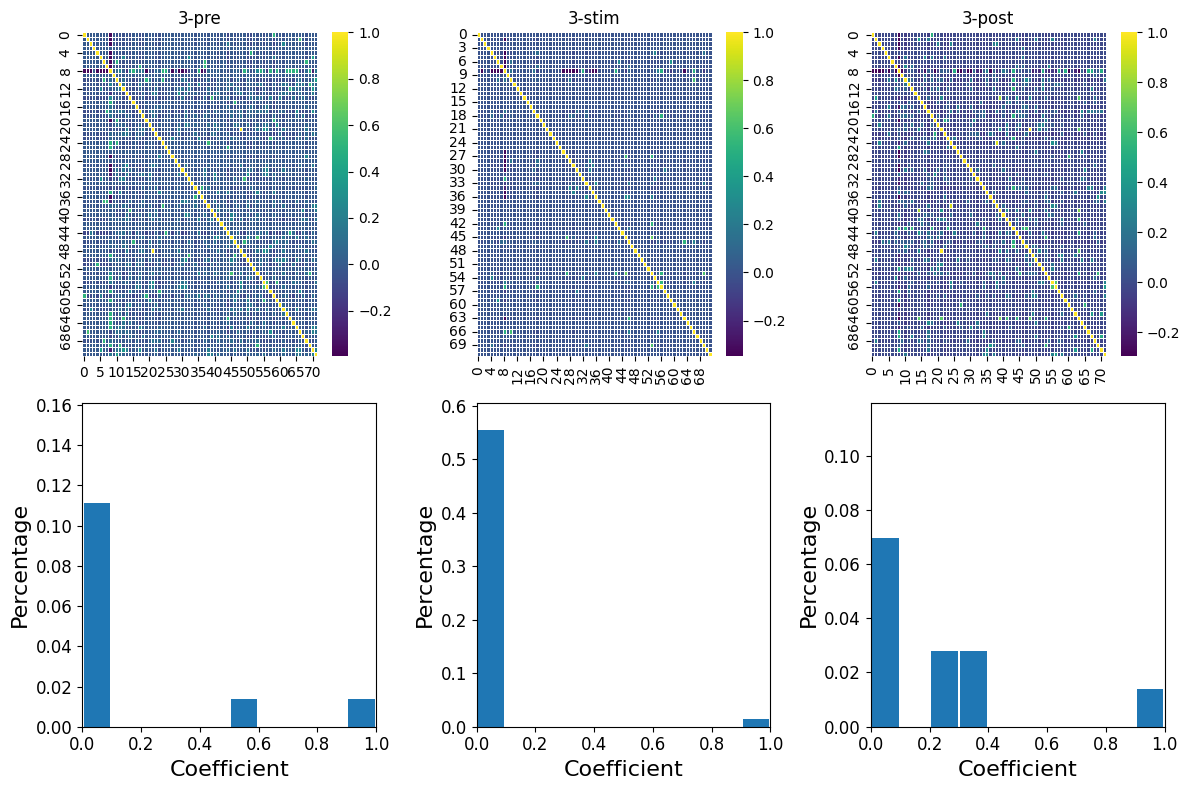

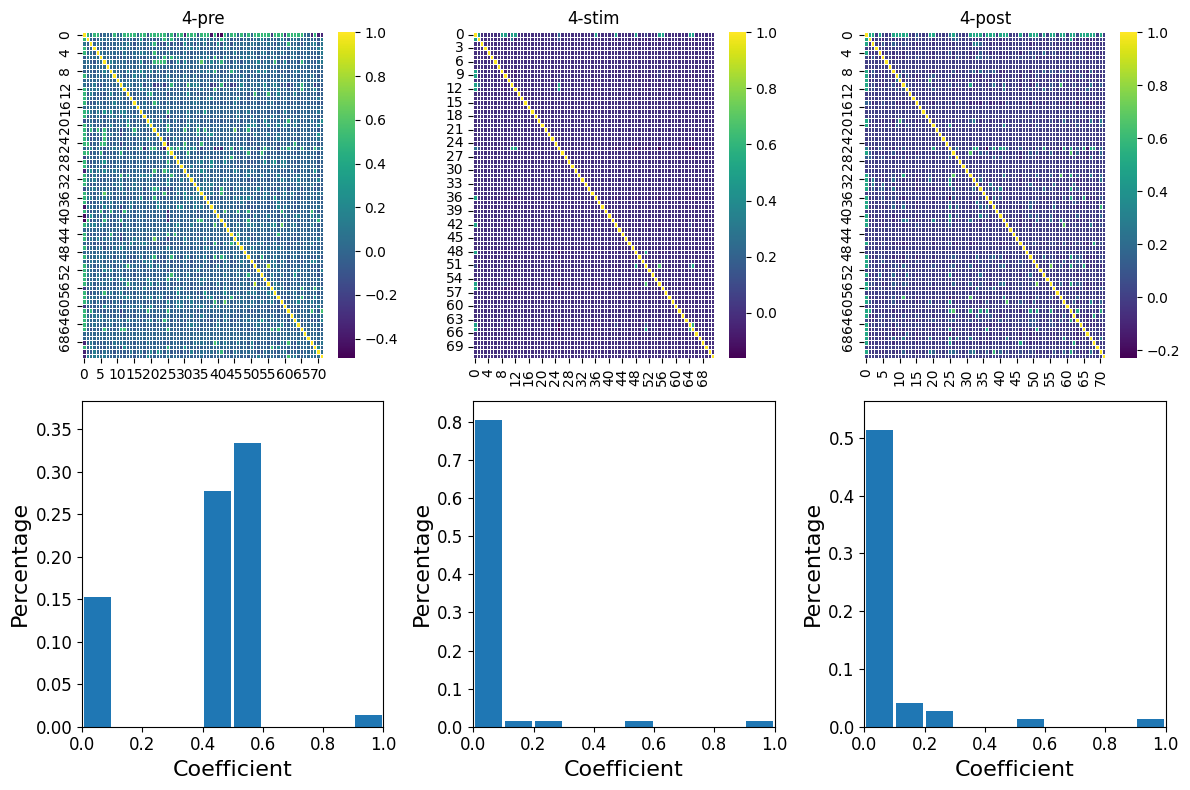

In [19]:

import seaborn as sns
for t in range(num_trial):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
    sections = ["pre", "stim", "post"]
    for i in range(len(sections)):
        sec = sections[i]
        spikes = analysis.SpikeData(st_trial_section[t][sec])
        sttc = spikes.spike_time_tilings(delt=0.02)
        # print(sttc.shape, np.unique(sttc))
        
        sns.heatmap(sttc, linewidth=0.5, cmap='viridis', ax=ax[0][i])
        ax[0][i].set_title(str(t) + "-" + sec)

        sttc_flat = sttc[i].ravel()
        n, _, _ = ax[1][i].hist(sttc_flat, bins=np.arange(0, 1.1, 0.1), 
                                weights=np.ones_like(sttc_flat)/len(sttc_flat), rwidth=0.9)
        ax[1][i].set_xlabel("Coefficient", fontsize=16)
        ax[1][i].set_ylabel("Percentage", fontsize=16)
        ax[1][i].xaxis.set_tick_params(labelsize=12)
        ax[1][i].yaxis.set_tick_params(labelsize=12)
        # ax[i].set_title(titles[i], fontsize=16)
        ax[1][i].set_xlim(0, 1)
        ax[1][i].set_ylim(0, max(n)+0.05)
    # plt.show(block=False)
